In [1]:
import numpy as N
import numpy.random as NR
import pandas
import tqdm
import seaborn

seaborn.set_style('whitegrid')

import tqdm
import torch as T
import torch.distributions as TD
import torch.distributions.constraints as TDC
import torch.nn as TN
import torch.nn.functional as TNF
import pyro as P
import pyro.infer as PI
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO, MCMC, NUTS
import pyro.optim as PO
import pyro.distributions as PD
import pyro.nn as PN
import matplotlib.pyplot as plt
P.set_rng_seed(0)

In [2]:
import sys
sys.path.append('..')
sys.path.append('../..')
sys.path.append('small')
import igg
import model
import guide_nn_small as guide
import guide_lstm_cell_small as guide_lstm_cell
M = 10

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
n0 = count_parameters(guide._nn_model_sub_l__i)
n1 = count_parameters(guide._nn__site0)
n2 = count_parameters(guide._nn_model_y)
n3 = count_parameters(guide._nn_model_x)
n4 = count_parameters(guide._nn_aggregate_result)
print("guide_nn_small:", n0, n1, n2, n3, n4, "total:", n0+n1+n2+n3+n4)
n0 = count_parameters(guide_lstm_cell.lstm)
n1 = count_parameters(guide_lstm_cell._nn_model_x)
n2 = count_parameters(guide_lstm_cell._nn_model_y)
n3 = count_parameters(guide_lstm_cell._nn_model_sub_l__i)
print("guide_lstm_cell_small:", n0, n1, n2, n3, "total:", n0+n1+n2+n3)

guide_nn_small: 90 152 34 42 104 total: 422
guide_lstm_cell_small: 384 18 18 18 total: 438


In [4]:
def draw(ind=True):
    if ind:
        return {"obs": 16.}  
    mu_1 = NR.uniform(-10, 10)
    mu_2 = NR.uniform(-10, 10)
    x_1 = NR.normal(mu_1, 3.0)
    y_1 = NR.normal(mu_2, 3.0)
    obs = NR.normal(x_1 * x_1 + y_1 * y_1, 0.5, (1,))
    return {"obs" : float(obs.astype('float32'))}
draw()

{'obs': 16.0}

In [5]:
def make_plot(x, y, main, savepath=None):
    plt.scatter(x, y, alpha=0.05)
    plt.title(main)
    plt.xlabel("x")
    plt.ylabel("y")
    if savepath:
        plt.savefig(savepath)
        plt.close()
    else:
        plt.show()

In [6]:

# nuts_kernel = NUTS(model.model)
# mcmc = MCMC(nuts_kernel, num_samples=1000)
# mcmc.run(M, {"obs":16.})
# model_samples = mcmc.get_samples()
# model_a = model_samples["x"].detach().numpy()
# model_b = model_samples["y"].detach().numpy()
# make_plot(model_a, model_b, main="model, obs="+str(16))

In [7]:
smoke_test = False

In [8]:
n_steps = 20000 if not smoke_test else 100
interval = 50 
num_inference_samples = 2000 if not smoke_test else 5
num_samples = 2000
obs_list = [draw(False) for _ in range(n_steps)]
steps = []
loss_lstm = []
loss_lstm_cell = []
loss_rnn = []
loss_nn = []

In [9]:
# importance = P.infer.Importance(model.model, num_samples=num_inference_samples)
# is_posterior = importance.run(M=M, observations={"obs": 16.})
# is_marginal = P.infer.EmpiricalMarginal(is_posterior, ["x", "y"])
# is_samples_x = []
# is_samples_y = []
# for _ in range(5000):
#     sample = is_marginal()
#     x = float(sample[0])
#     y = float(sample[1])
#     is_samples_x.append(x)
#     is_samples_y.append(y)
# make_plot(is_samples_x, is_samples_y, main=f"IS, obs={16}, ess={T.round(importance.get_ESS())}")

In [10]:
def sample_posterior(csis, num_samples=num_samples, obs=16.):
    if smoke_test:
        num_samples = 100
    posterior = csis.run(M=M, observations={"obs": obs})
    marginal = P.infer.EmpiricalMarginal(posterior, ["x", "y"])
    csis_samples_x = []
    csis_samples_y = []
    for _ in range(num_samples):
        sample = marginal()
        x = float(sample[0])
        y = float(sample[1])
        csis_samples_x.append(x)
        csis_samples_y.append(y)
    return csis_samples_x, csis_samples_y
def sample_x_y_guide(guide_fn, num_samples=num_samples, obs=16.):
    if smoke_test:
        num_samples = 100
    guide_x = []
    guide_y = []
    for _ in range(num_samples):
        x, y =guide_fn(M, {"obs" : obs})
        guide_x.append(float(x))
        guide_y.append(float(y))
    return guide_x, guide_y   
    

In [11]:
P.clear_param_store()
optimiser = PO.Adam({"lr": 0.001})
csis = PI.CSIS(model.model, guide_lstm_cell.model, optimiser, num_inference_samples=num_inference_samples)

avg_l = 0
for step in tqdm.trange(n_steps):
    obs = obs_list[step]
    loss = csis.step(M, observations=obs)
    avg_l += loss
    if (step + 1) % interval == 0:
        loss_lstm_cell.append(N.log(avg_l))
        avg_l = 0

guide_x, guide_y = sample_posterior(csis)
ess = csis.get_ESS()
make_plot(guide_x, guide_y, main=f"LSTM_W/_IS, M={M}, ESS={T.round(ess)}", savepath=f"figures/lstm_is_{M}.png")
guide_fn_x, guide_fn_y = sample_x_y_guide(guide_lstm_cell.model)
make_plot(guide_fn_x, guide_fn_y, main=f"LSTM_W/O_IS, M={M}, ESS={T.round(ess)}", savepath=f"figures/lstm_nn_{M}.png")
print(ess)
print(guide_x, guide_y)
print(guide_fn_x, guide_fn_y)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [36:35<00:00,  9.11it/s]


tensor(102.7318)
[11.006044387817383, 5.354763031005859, 8.180994987487793, 3.194249391555786, 15.402304649353027, 20.04629898071289, 14.257220268249512, 8.341774940490723, 3.36354660987854, 5.573256492614746, -0.8694901466369629, 10.366493225097656, 7.212193012237549, 3.36354660987854, 22.34206771850586, 10.623620986938477, 17.79115867614746, 12.585356712341309, 8.180994987487793, 0.0903329849243164, 6.029104232788086, 17.383209228515625, 2.6674888134002686, 3.7386982440948486, 14.594961166381836, 12.09531307220459, 2.093738555908203, 15.960539817810059, 6.734919548034668, 2.6674888134002686, 10.018725395202637, 1.7264289855957031, 11.414508819580078, 20.70467758178711, 15.732449531555176, 8.669557571411133, 11.641502380371094, 11.786262512207031, 14.314676284790039, 3.194249391555786, 10.077664375305176, 10.077664375305176, 8.345985412597656, 5.768933296203613, 3.7340481281280518, 8.669557571411133, 9.405211448669434, 8.180994987487793, 10.797018051147461, 22.34206771850586, 5.573256

In [12]:
P.clear_param_store()
optimiser = PO.Adam({"lr": 0.001})
csis = PI.CSIS(model.model, guide.model, optimiser, num_inference_samples=num_inference_samples)

avg_l = 0
for step in tqdm.trange(n_steps):
    obs = obs_list[step]
    loss = csis.step(M, observations=obs)
    avg_l += loss
    if (step + 1) % interval == 0:
        steps.append(step)
        loss_nn.append(N.log(avg_l))
        avg_l = 0

guide_x, guide_y = sample_posterior(csis)
ess = csis.get_ESS()
make_plot(guide_x, guide_y, main=f"IGG_W/_IS, M={M}, ESS={T.round(ess)}", savepath=f"figures/igg_is_{M}.png")
guide_fn_x, guide_fn_y = sample_x_y_guide(guide.model)
make_plot(guide_fn_x, guide_fn_y, main=f"IGG_W/O_IS, M={M}, ESS={T.round(ess)}", savepath=f"figures/igg_nn_{M}.png")
print(ess)
print(guide_x, guide_y)
print(guide_fn_x, guide_fn_y)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [51:58<00:00,  6.41it/s]


tensor(325.0202)
[8.675555229187012, 6.375715255737305, 5.61700963973999, 3.8787803649902344, 7.060327053070068, 8.583139419555664, 7.7653913497924805, 19.40846824645996, 6.8642897605896, 8.86591911315918, -2.0567736625671387, 4.633554458618164, 16.101919174194336, 6.941924571990967, -0.626032292842865, 7.890584945678711, 5.676883697509766, -2.042544364929199, 10.753361701965332, 5.0805864334106445, 13.479323387145996, 2.1981043815612793, 19.398374557495117, 1.6600261926651, 8.015837669372559, 3.1433756351470947, 12.966409683227539, 16.7613525390625, 13.358049392700195, 8.220125198364258, 15.186844825744629, -3.7285969257354736, -1.7853443622589111, 13.545844078063965, 17.899080276489258, 5.441173553466797, 25.529165267944336, 15.063862800598145, 8.428715705871582, 13.19510269165039, 9.551690101623535, 7.854090690612793, 9.909911155700684, 13.52135181427002, 2.747370958328247, 6.829016208648682, -1.4378080368041992, 10.97504711151123, 19.398374557495117, -5.86008882522583, 10.001605987

In [13]:
# P.clear_param_store()

# optimiser = PO.Adam({"lr": 0.001})
# csis = PI.CSIS(model.model, guide_rnn.model, optimiser, num_inference_samples=num_inference_samples)

# avg_l = 0
# for step in tqdm.trange(n_steps):
#     obs = obs_list[step]
#     loss = csis.step(M, observations=obs)
#     avg_l += loss
#     if (step + 1) % interval == 0:
#         loss_rnn.append(N.log(avg_l))
#         avg_l = 0
# guide_rnn_x, guide_rnn_y = sample_posterior(csis)
# ess = csis.get_ESS()
# make_plot(guide_rnn_x, guide_rnn_y, main=f"guide_rnn, obs={16}, ess={T.round(ess)}")
# guide_fn_x, guide_fn_y = sample_x_y_guide(guide_rnn.model)
# make_plot(guide_fn_x, guide_fn_y, main=f"guide_rnn direct from guide, obs={16}, ess={T.round(ess)}")

In [14]:
# P.clear_param_store()

# optimiser = PO.Adam({"lr": 0.001})
# csis = PI.CSIS(model.model, guide_lstm.model, optimiser, num_inference_samples=num_inference_samples)

# avg_l = 0
# for step in tqdm.trange(n_steps):
#     obs = obs_list[step]
#     loss = csis.step(M, observations=obs)
#     avg_l += loss
#     if (step + 1) % interval == 0:
#         steps.append(step)
#         loss_lstm.append(N.log(avg_l))
#         avg_l = 0
# guide_lstm_x, guide_lstm_y = sample_posterior(csis)
# ess = csis.get_ESS()
# make_plot(guide_lstm_x, guide_lstm_y, main=f"guide_lstm, obs={16}, ess={T.round(ess)}")
# guide_fn_x, guide_fn_y = sample_x_y_guide(guide_lstm.model)
# make_plot(guide_fn_x, guide_fn_y, main=f"guide_lstm direct from guide, obs={16}, ess={T.round(ess)}")

observations to train is not a single point

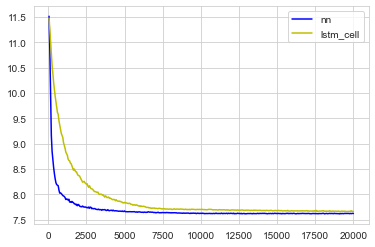

In [15]:
#plt.plot(steps, loss_lstm, "-r", label="lstm")
plt.plot(steps, loss_nn, "-b", label="nn")
plt.plot(steps, loss_lstm_cell, "-y", label="lstm_cell")
#plt.plot(steps, loss_rnn, "-g", label="rnn")
plt.legend()
plt.show()

In [16]:
# P.clear_param_store()

# optimiser = PO.Adam({"lr": 0.001})
# csis = PI.CSIS(model.model, guide_lstm.model, optimiser, num_inference_samples=num_inference_samples)

# avg_l = 0
# for step in tqdm.trange(n_steps):
#     obs = obs_list[step]
#     loss = csis.step(M, observations=obs)
#     avg_l += loss
#     if (step + 1) % interval == 0:
#         steps.append(step)
#         loss_lstm.append(N.log(avg_l))
#         avg_l = 0
# guide_lstm_x, guide_lstm_y = sample_posterior(csis)
# ess = csis.get_ESS()
# make_plot(guide_lstm_x, guide_lstm_y, main=f"guide_lstm, obs={16}, ess={T.round(ess)}")
# guide_fn_x, guide_fn_y = sample_x_y_guide(guide_lstm.model)
# make_plot(guide_fn_x, guide_fn_y, main=f"guide_lstm direct from guide, obs={16}, ess={T.round(ess)}")

In [17]:
# plt.plot(steps, loss_lstm, "-r", label="lstm")
# plt.plot(steps, loss_nn, "-b", label="nn")
# plt.legend()
# plt.show()



### 